# PROJECT 2: 
## MODEL ANALYSIS PROJECT# Model Project

ProgEcon: Project 2

Group: Nikolaj Bysted and Fanny Troelsen Vindeløv

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# user written modules
import modelproject
from Worker import WorkerClass
from Government import GovernmentClass

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Part 1: Labor supply

## 1.1 Numerical optimizer vs root-finder

__Summary of Findings:__

For all values of $\epsilon \in \{1.0, 0.75, 0.5\}$ the numerical optimizer and the root-finder produce nearly the same optimal labor supply. As $\epsilon$ decreases, the disutility of labor becomes weaker and the optimal labor supply increases. At $\epsilon =0.5$ the upper bound is reached. 

The utility and FOC plots confirm this: both the utility maximum and the zero of the FOC shift to higher labor levels as $\epsilon $ falls. The optimizer handles boundary solutions more reliably, while the root-finder is faster for interior solutions. Overall, both methods are consistent and yield identical results.

epsilon = 1.0
  ell* (optimizer):   8.265578
  ell* (root finder): 8.265578



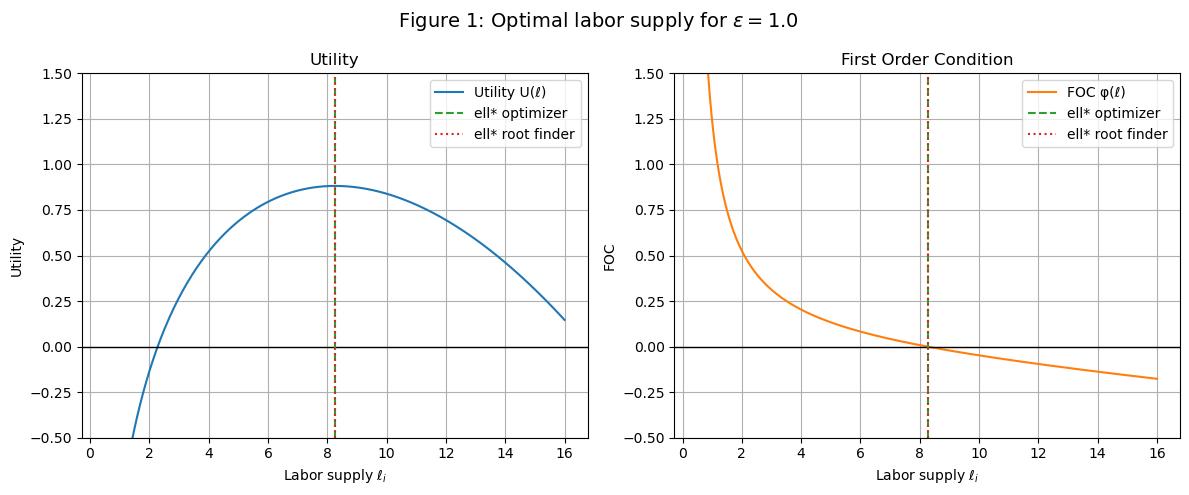

epsilon = 0.75
  ell* (optimizer):   11.136048
  ell* (root finder): 11.136048



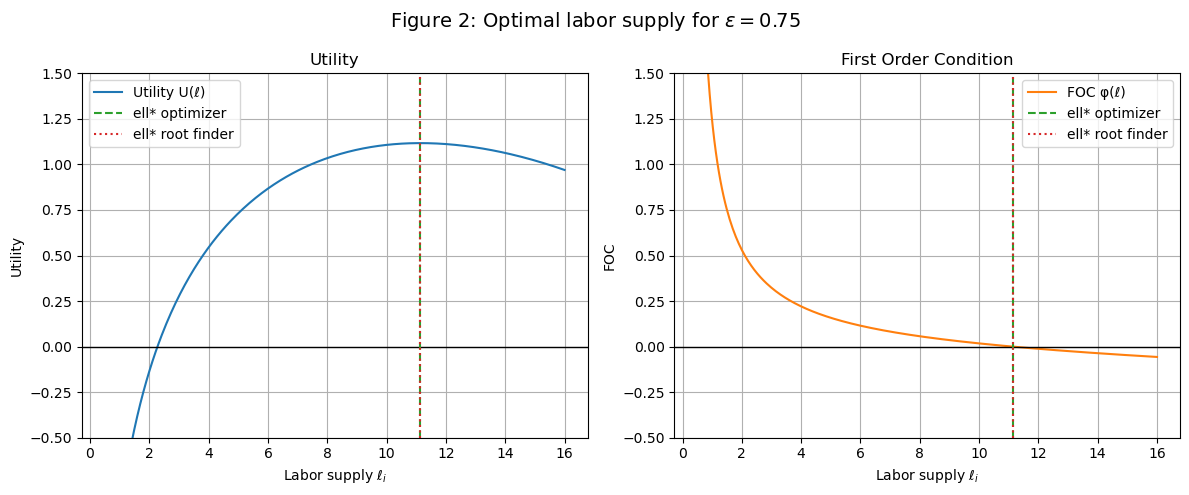

epsilon = 0.5
  ell* (optimizer):   15.999996
  ell* (root finder): 16.000000



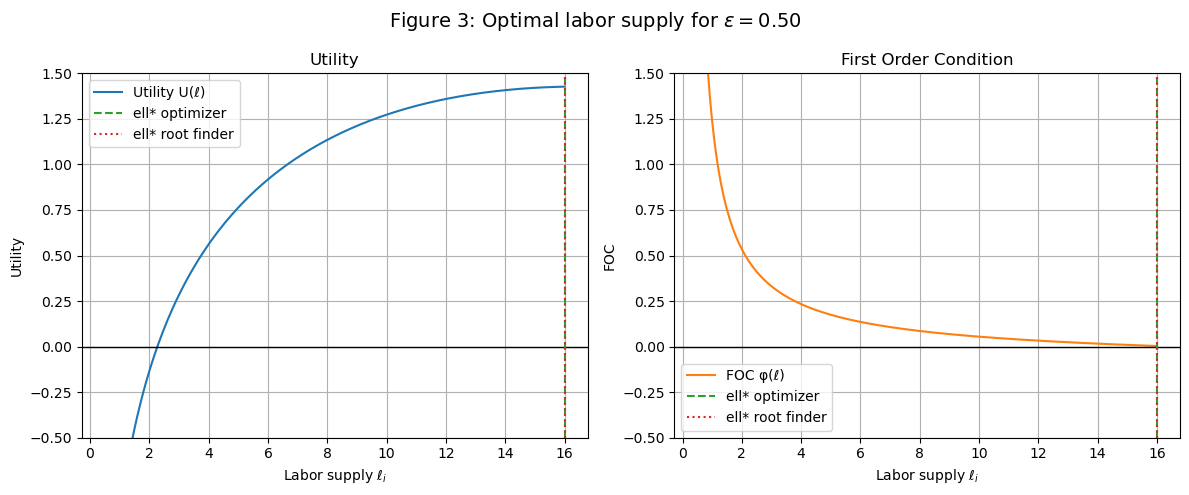

In [49]:
worker = WorkerClass()
p = 1.0

worker.plot_for_epsilon(1.0,  p, r' Figure 1: Optimal labor supply for $\epsilon = 1.0$')
worker.plot_for_epsilon(0.75, p, r'Figure 2: Optimal labor supply for $\epsilon = 0.75$')
worker.plot_for_epsilon(0.50, p, r'Figure 3: Optimal labor supply for $\epsilon = 0.50$')


## 1.2 Labor supply function

__Summary of Findings :__
Figure 4 shows that positive and negative lump-sum taxes affect labor supply in opposite directions, with a positive tax increasing hours worked and a negative tax reducing them.

Higher productivity increases the effective wage, generating both substitution and income effects. In this model, the income effect dominates, so labor supply varies only weakly with productivity. A positive lump-sum tax raises labor supply, especially for low-productivity workers, while a lump-sum transfer reduces labor supply through an income effect.


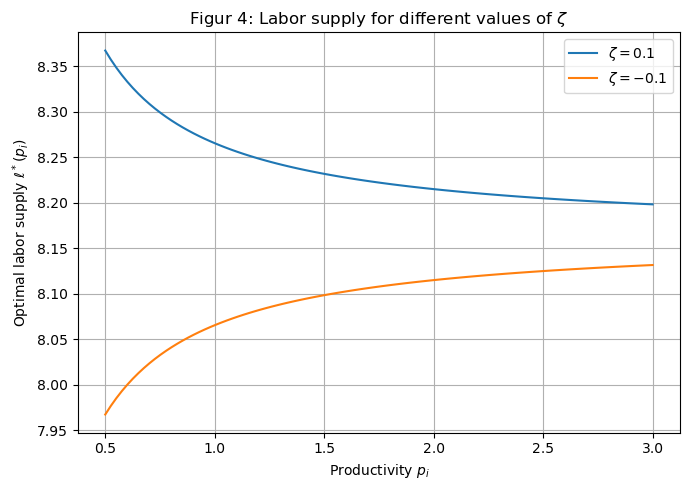

In [50]:
worker.plot_labor_supply(0.10, -0.10) 

# 2. Public good

## 2.1 Tax revenue and SocialWelfare Function

For τ = 0.50 and ζ = 0.10, we draw productivities, solve households’ labor supply problems, and compute total tax revenue and social welfare. The resulting values of T and SWF are reported below

In [51]:
from Government import GovernmentClass

zeta_values = [-0.1, 0.0, 0.1]
tau = 0.50  
tau_int = np.linspace(0.01, 0.8, 100)


for z in zeta_values:
    gov = GovernmentClass()
    gov.par.tau = tau
    gov.par.zeta = z

    gov.draw_productivities()
    gov.solve_workers()

    T = gov.tax_revenue()
    SWF = gov.SWF()

    print(f"zeta = {z}: T = {T:.3f}, SWF = {SWF:.3f}")
    #test

zeta = -0.1: T = 387.911, SWF = 178.742
zeta = 0.0: T = 402.877, SWF = 176.418
zeta = 0.1: T = 417.910, SWF = 174.045


In [52]:
T_results = {z: [] for z in zeta_values}
SWF_results = {z: [] for z in zeta_values}

for z in zeta_values:
    for tau in tau_int:
        gov = GovernmentClass()
        gov.par.tau = tau
        gov.par.zeta = z

        gov.draw_productivities()
        gov.solve_workers()

        T_results[z].append(gov.tax_revenue())
        SWF_results[z].append(gov.SWF())

tau_star = {}
SWF_star = {}

for z in zeta_values:
    SWF_array = np.array(SWF_results[z])
    idx = np.nanargmax(SWF_array)

    tau_star[z] = tau_int[idx]
    SWF_star[z] = SWF_array[idx]

    print(f"zeta = {z}: tau* = {tau_star[z]:.3f}, SWF* = {SWF_star[z]:.3f}")

zeta = -0.1: tau* = 0.082, SWF* = 222.272
zeta = 0.0: tau* = 0.066, SWF* = 222.205
zeta = 0.1: tau* = 0.058, SWF* = 222.151


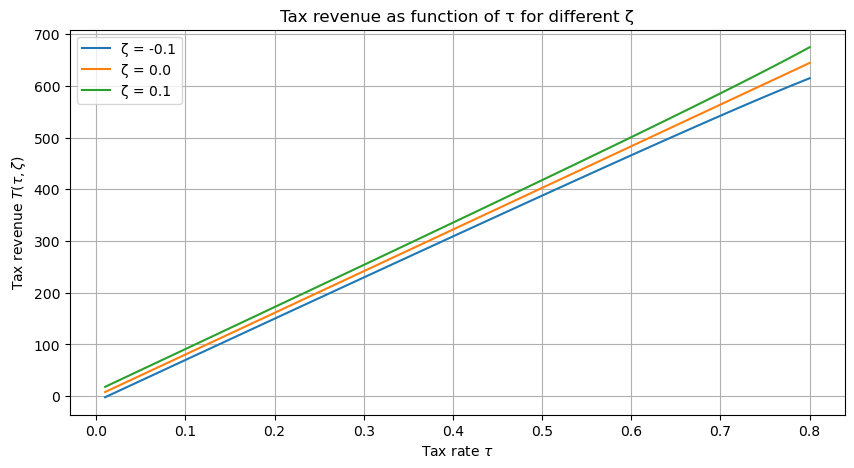

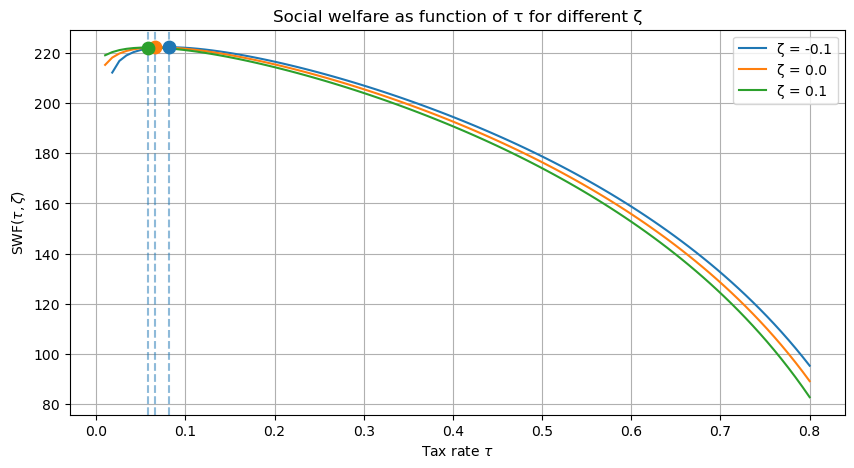

In [53]:
plt.figure(figsize=(10,5))
for z in zeta_values:
    plt.plot(tau_int, T_results[z], label=f"ζ = {z}")

plt.xlabel(r"Tax rate $\tau$")
plt.ylabel(r"Tax revenue $T(\tau,\zeta)$")
plt.title("Tax revenue as function of τ for different ζ")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10,5))

for z in zeta_values:
    plt.plot(tau_int, SWF_results[z], label=f"ζ = {z}")

    # marker maksimum
    plt.scatter(
        tau_star[z],
        SWF_star[z],
        s=80,
        zorder=5
    )

    plt.axvline(
        tau_star[z],
        linestyle="--",
        alpha=0.5
    )

plt.xlabel(r"Tax rate $\tau$")
plt.ylabel(r"SWF($\tau,\zeta$)")
plt.title("Social welfare as function of τ for different ζ")
plt.legend()
plt.grid(True)
plt.show()


## 2.2 Optimal tax system

__2.2.1 and 2.2.2__:



In [54]:
from scipy.optimize import minimize
import numpy as np
from Government import GovernmentClass

# ============================================================
# Objective function: negative SWF
# ============================================================
def obj_SWF(x):
    tau, zeta = x

    # Impose simple bounds manually (Nelder-Mead has no bounds)
    if tau <= 0 or tau >= 1:
        return 1e12
    if zeta < -1 or zeta > 1:
        return 1e12

    gov = GovernmentClass()
    gov.par.tau = float(tau)
    gov.par.zeta = float(zeta)

    gov.draw_productivities()
    gov.solve_workers()

    SWF_val = gov.SWF()

    if SWF_val is None or not np.isfinite(SWF_val):
        return 1e12

    return -SWF_val


# ============================================================
# Run optimization
# ============================================================
x_init = np.array([0.3, 0.0])  # initial guess

result = minimize(
    obj_SWF,
    x0=x_init,
    method="Nelder-Mead",
    options={"maxiter": 3000, "xatol": 1e-6, "fatol": 1e-6}
)

tau_star, zeta_star = result.x

print("Optimal tau*  =", tau_star)
print("Optimal zeta* =", zeta_star)
print("Maximum SWF  =", -result.fun)


# ------------------------------------------------------------
# Different starting values
# ------------------------------------------------------------
start_points = [
    [0.1, -0.5],
    [0.3,  0.0],
    [0.6,  0.3],
    [0.8, -0.2]
]

solutions = []

for x0 in start_points:
    res = minimize(
        obj_SWF,
        x0=np.array(x0, dtype=float),
        method="Nelder-Mead",
        options={"maxiter": 3000}
    )

    solutions.append(res.x)
    print(f"Start {x0} -> tau* = {res.x[0]:.4f}, zeta* = {res.x[1]:.4f}")


# ------------------------------------------------------------
# Check convergence
# ------------------------------------------------------------
solutions = np.array(solutions)

tau_vals = solutions[:, 0]
zeta_vals = solutions[:, 1]

print("\nRange of solutions:")
print("tau*:  min =", tau_vals.min(), "max =", tau_vals.max())
print("zeta*: min =", zeta_vals.min(), "max =", zeta_vals.max())



Optimal tau*  = 0.1368174522313298
Optimal zeta* = -0.5238333562030255
Maximum SWF  = 222.38398835459213
Start [0.1, -0.5] -> tau* = 0.1369, zeta* = -0.5241
Start [0.3, 0.0] -> tau* = 0.1368, zeta* = -0.5238
Start [0.6, 0.3] -> tau* = 0.1369, zeta* = -0.5242
Start [0.8, -0.2] -> tau* = 0.1369, zeta* = -0.5240

Range of solutions:
tau*:  min = 0.13681625035285871 max = 0.1368570222050104
zeta*: min = -0.5241617584685742 max = -0.5238284653552091


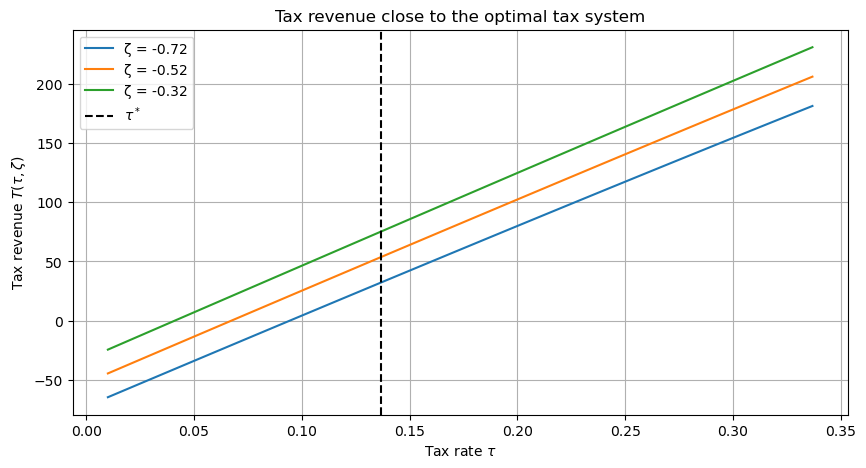

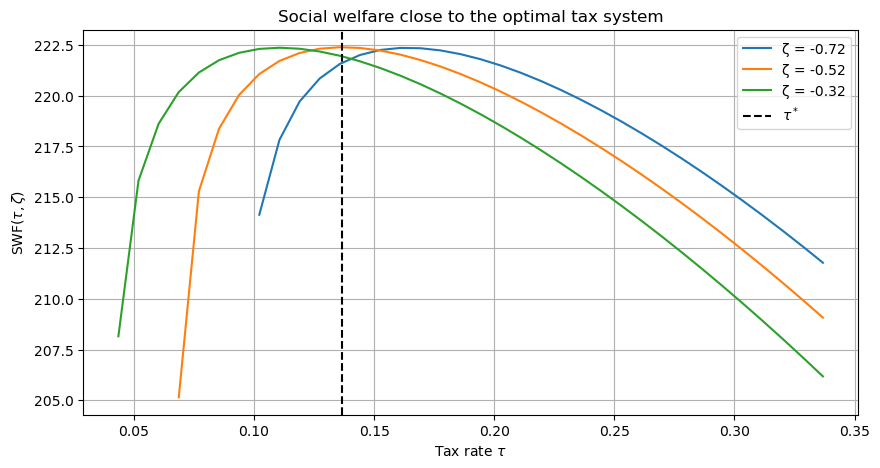

In [55]:
#Opgave 2.2.3

import numpy as np
import matplotlib.pyplot as plt
from Government import GovernmentClass

# Local grid around optimum
tau_values = np.linspace(
    max(0.01, tau_star - 0.2),
    min(0.99, tau_star + 0.2),
    40
)

zeta_values = [
    zeta_star - 0.2,
    zeta_star,
    zeta_star + 0.2
]

T_results = {z: [] for z in zeta_values}
SWF_results = {z: [] for z in zeta_values}

for z in zeta_values:
    for tau in tau_values:
        gov = GovernmentClass()
        gov.par.tau = tau
        gov.par.zeta = z

        gov.draw_productivities()
        gov.solve_workers()

        T_results[z].append(gov.tax_revenue())
        SWF_results[z].append(gov.SWF())

plt.figure(figsize=(10,5))
for z in zeta_values:
    plt.plot(tau_values, T_results[z], label=f"ζ = {z:.2f}")

plt.axvline(tau_star, linestyle="--", color="black", label=r"$\tau^*$")
plt.xlabel(r"Tax rate $\tau$")
plt.ylabel(r"Tax revenue $T(\tau,\zeta)$")
plt.title("Tax revenue close to the optimal tax system")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
for z in zeta_values:
    plt.plot(tau_values, SWF_results[z], label=f"ζ = {z:.2f}")

plt.axvline(tau_star, linestyle="--", color="black", label=r"$\tau^*$")
plt.xlabel(r"Tax rate $\tau$")
plt.ylabel(r"SWF($\tau,\zeta$)")
plt.title("Social welfare close to the optimal tax system")
plt.legend()
plt.grid(True)
plt.show()


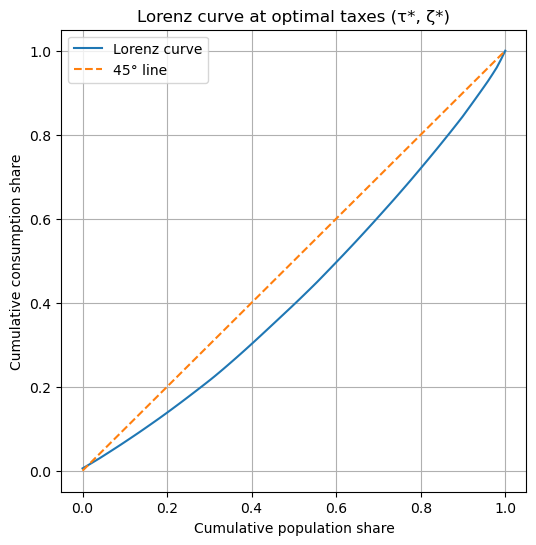

In [56]:

# ============================================================
# 5. Lorenz curve for consumption at optimum
# ============================================================

gov = GovernmentClass()
gov.par.tau = tau_star
gov.par.zeta = zeta_star

gov.draw_productivities()
gov.solve_workers()

pi = gov.sol.pi
l = gov.sol.l
c = (1 - tau_star) * gov.par.w * pi * l - zeta_star  # FIXED: missing * signs

# Lorenz curve
c_sorted = np.sort(c)
cumsum_rel = np.cumsum(c_sorted) / np.sum(c_sorted)
pop = np.linspace(0, 1, len(c))

plt.figure(figsize=(6,6))
plt.plot(pop, cumsum_rel, label="Lorenz curve")
plt.plot([0,1], [0,1], '--', label="45° line")
plt.xlabel("Cumulative population share")
plt.ylabel("Cumulative consumption share")
plt.title("Lorenz curve at optimal taxes (τ*, ζ*)")
plt.legend()
plt.grid(True)
plt.show()

# 3. Top tax

## 3.1 Labor supply

__Summary of Findings :__

For all values of p, the numerical optimizer and the four-step FOC method yield the same optimal labor supply.
The utility function has a single interior maximum, and the FOC crosses zero at exactly this point.
In all cases, the optimal labor supply lies below the top-tax kink, so the pre–top-tax FOC determines the solution. After the kink, the FOC is strictly negative, implying no interior optimum in that region.
Thus, while the top tax changes the shape of the FOC, it does not affect the optimal labor choice.

As p increases, the optimal labor supply decreases, reflecting weaker labor incentives due to a higher effective tax burden, while the top tax itself does not change the location of the optimum.

ℓ* (optimizer) = 7.867170617, U = 1.525684708
ℓ* (4-step FOC) = 7.867170627, U = 1.525684708


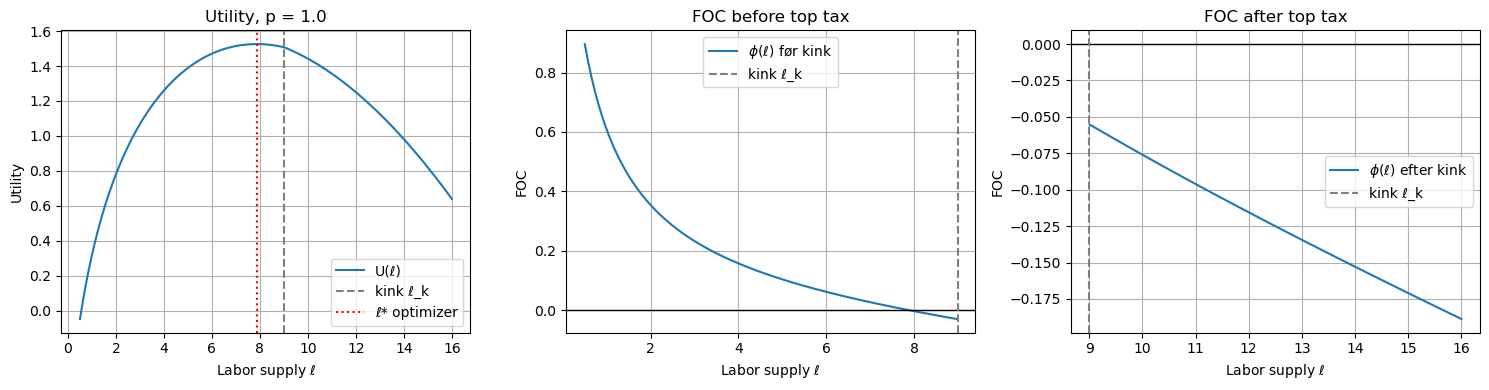

ℓ* (optimizer) = 7.659574271, U = 1.675330523
ℓ* (4-step FOC) = 7.659574468, U = 1.675330524


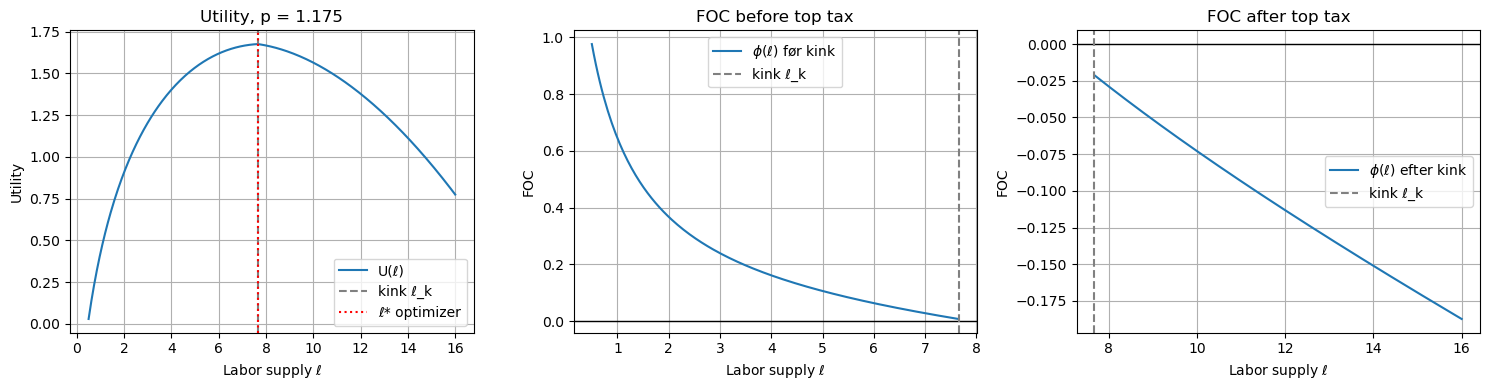

ℓ* (optimizer) = 7.080066787, U = 1.861226940
ℓ* (4-step FOC) = 7.080066065, U = 1.861226940


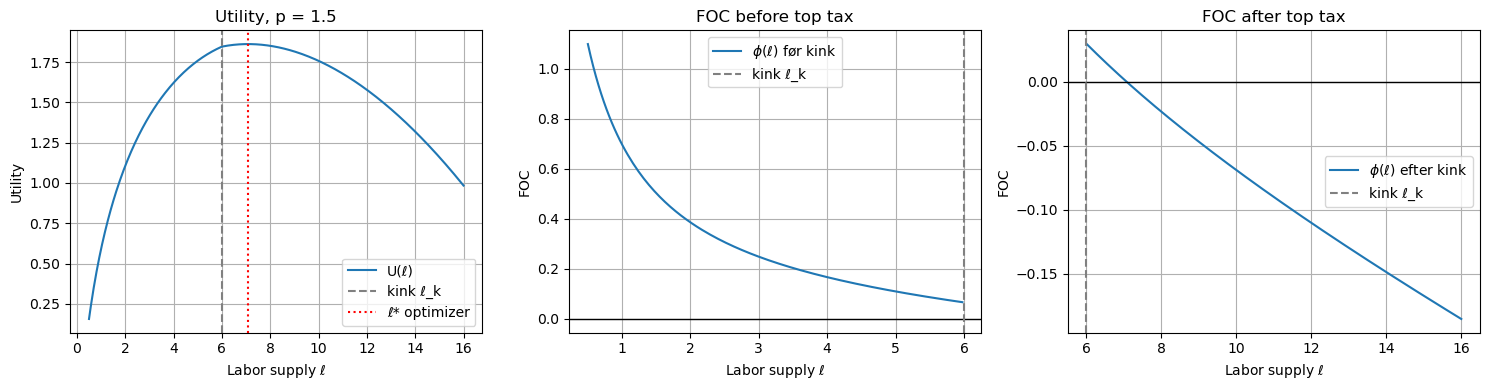

In [66]:
from Worker import WorkerClass
worker = WorkerClass()


worker.par.tau_star = tau_star
worker.par.zeta_star = zeta_star


worker.plot_top_tax(1.0)
worker.plot_top_tax(1.175)
worker.plot_top_tax(1.5)

## 3.2 Labor supply function

__Summary of Findings :__

Labor supply increases with productivity. Almost no one chooses the before-kink solution, a small share works Optimal labor supply increases with productivity but shows a discrete drop around the top-tax kink due to the higher marginal tax rate. 

Consumption rises monotonically with productivity, with a clear flattening near the kink reflecting reduced after-tax returns.

Most workers choose the after-kink region (64%), while smaller shares locate before the kink (24%) or exactly at it (12%), indicating localized behavioral effects of the top tax.

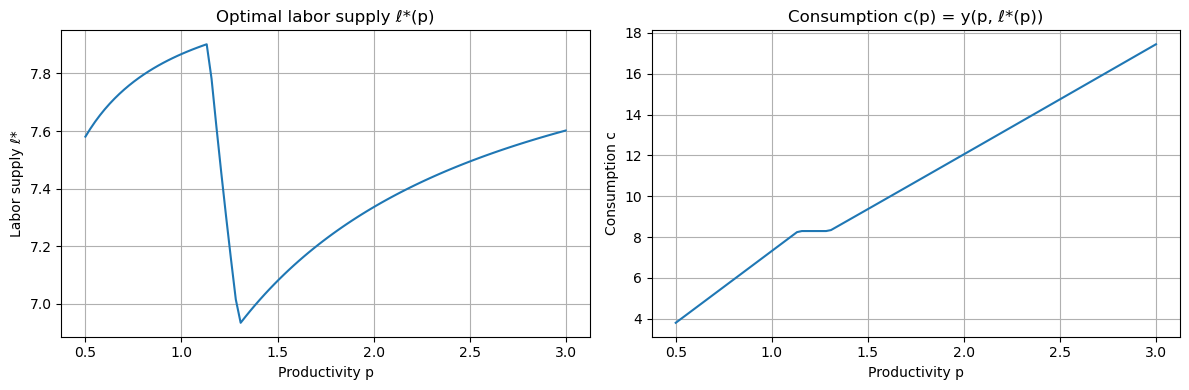

Share with ℓ* = ℓ^b (before kink): 0.260
Share with ℓ* = ℓ^k (at kink):      0.060
Share with ℓ* = ℓ^a (after kink):   0.680


In [67]:
worker.plot_labor_and_consumption_top()
share_b, share_k, share_a = worker.region_proportions_top()

## 3.3 Public good

In [70]:


gov = GovernmentClass()

# Important: draw productivities ONCE so baseline vs top tax is comparable
gov.draw_productivities()

# ---- baseline (no top tax) ----
gov.par.omega = 0.0
gov.par.kappa = 9.0  # irrelevant when omega=0

gov.solve_workers()
SWF_baseline = gov.SWF()

# ---- with top tax ----
gov.par.omega = 0.2
gov.par.kappa = 9.0

gov.solve_workers()
SWF_top = gov.SWF()

print(f"SWF without top tax: {SWF_baseline:.6f}")
print(f"SWF with top tax:    {SWF_top:.6f}")
print(f"Change in SWF:       {(SWF_top - SWF_baseline):.6f}")


SWF without top tax: 174.045268
SWF with top tax:    172.470685
Change in SWF:       -1.574584


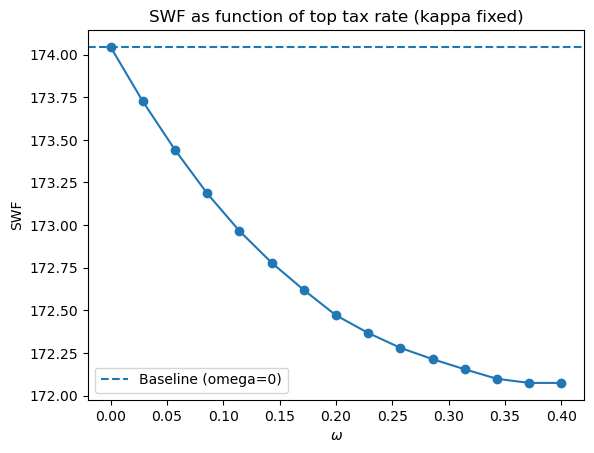

In [71]:
gov.par.kappa = 9.0
omegas = np.linspace(0.0, 0.4, 15)

SWFs = []
for omega in omegas:
    gov.par.omega = omega
    gov.solve_workers()
    SWFs.append(gov.SWF())

plt.figure()
plt.plot(omegas, SWFs, marker='o')
plt.axhline(SWF_baseline, linestyle='--', label='Baseline (omega=0)')
plt.xlabel(r'$\omega$')
plt.ylabel('SWF')
plt.title('SWF as function of top tax rate (kappa fixed)')
plt.legend()
plt.show()


In [ ]:
from Worker import WorkerClass
from Government import GovernmentClass

# ---------- 0) Draw ONE fixed productivity sample (same for all comparisons) ----------
gov = GovernmentClass()
gov.draw_productivities()
pi_draw = gov.sol.pi.copy()


N   = gov.par.N
w   = gov.par.w
chi = gov.par.chi
eta = gov.par.eta


def lorenz_curve(x):
    #Return population shares and cumulative shares for Lorenz curve.
    x = np.asarray(x)
    x = np.maximum(x, 0.0)
    xs = np.sort(x)
    cum = np.cumsum(xs)
    if cum[-1] == 0:
        pop = np.linspace(0, 1, len(xs))
        return pop, pop  # degenerate
    L = cum / cum[-1]
    pop = np.linspace(0, 1, len(xs))
    return pop, L

def eval_no_top_tax(pi, tau, zeta):
    #Economy evaluation WITHOUT top tax using GovernmentClass' worker-solver.
    gov = GovernmentClass()
    gov.sol.pi = pi.copy()
    gov.par.tau = float(tau)
    gov.par.zeta = float(zeta)

    gov.solve_workers()

    # revenue and SWF from your GovernmentClass
    G = gov.tax_revenue()
    swf = gov.SWF()

    # consumption under baseline (no top tax)
    c = (1 - tau) * w * gov.sol.pi * gov.sol.l - zeta
    return swf, G, c, gov.sol.l, gov.sol.U

def eval_top_tax(pi, tau_star, zeta_star, kappa, omega, use_foc=False):
    # Economy evaluation WITH top tax. We solve each worker using WorkerClass' top-tax methods (already in your Worker.py).
    
    worker = WorkerClass()
    worker.par.tau_star = float(tau_star)
    worker.par.zeta_star = float(zeta_star)
    worker.par.kappa = float(kappa)
    worker.par.omega = float(omega)

    ell = np.zeros_like(pi)
    U   = np.zeros_like(pi)
    c   = np.zeros_like(pi)

    for i, p in enumerate(pi):
        opt = worker.optimal_choice_top_FOC(p) if use_foc else worker.optimal_choice_top(p)
        ell[i] = opt.ell
        c[i]   = opt.c
        U[i]   = opt.U

    pre_tax = w * pi * ell
    top_base = np.maximum(pre_tax - kappa, 0.0)

    # tax revenue: T = N*zeta + sum(tau*pre_tax + omega*top_base)
    G = N * zeta_star + np.sum(tau_star * pre_tax + omega * top_base)

    # SWF = chi*G^eta + sum(U)
    swf = np.nan if (G < 0) else chi * (G ** eta) + np.sum(U)

    return swf, G, c, ell, U

# ============================================================
# 3.3.1) SWF change when introducing the top tax (kappa=9, omega=0.2)
# ============================================================

# baseline: no top tax, but at (tau*, zeta*)
SWF0, G0, c0, ell0, U0 = eval_no_top_tax(pi_draw, tau_star, zeta_star)

# top tax baseline parameters from assignment text
kappa0 = 9.0
omega0 = 0.20
SWF1, G1, c1, ell1, U1 = eval_top_tax(pi_draw, tau_star, zeta_star, kappa0, omega0, use_foc=False)

print("=== 3.3.1: SWF effect of introducing top tax (kappa=9, omega=0.2) ===")
print(f"No top tax:     SWF = {SWF0:.6f},  G = {G0:.6f}")
print(f"With top tax:   SWF = {SWF1:.6f},  G = {G1:.6f}")
print(f"Change:         ΔSWF = {SWF1-SWF0:.6f},  ΔG = {G1-G0:.6f}")

# ============================================================
#  Lorenz curve change (consumption) when introducing top tax
# ============================================================

pop0, L0 = lorenz_curve(c0)
pop1, L1 = lorenz_curve(c1)

plt.figure(figsize=(6,6))
plt.plot(pop0, L0, label="No top tax (τ*, ζ*)")
plt.plot(pop1, L1, label="With top tax (κ=9, ω=0.2)")
plt.plot([0,1],[0,1],'--', label="45° line")
plt.xlabel("Cumulative population share")
plt.ylabel("Cumulative consumption share")
plt.title("Lorenz curves: consumption before vs after top tax")
plt.grid(True)
plt.legend()
plt.show()

# ============================================================
# Grid search for (omega, kappa) that improves SWF
# (tau_star, zeta_star fixed)
# ============================================================

# Baseline SWF without top tax (at tau_star, zeta_star)
SWF0, G0, c0, ell0, U0 = eval_no_top_tax(pi_draw, tau_star, zeta_star)

# Constraint: omega < 1 - tau_star
omega_max = 1.0 - tau_star - 1e-8
if omega_max <= 0:
    raise ValueError(f"omega_max <= 0 because tau_star={tau_star:.4f}. Need tau_star < 1.")

# Choose grids 
omega_grid = np.linspace(0.0, min(0.6, omega_max), 31)   
kappa_grid = np.linspace(5.0, 14.0, 41)                 

best = {"SWF": -np.inf, "omega": None, "kappa": None, "G": None}
SWF_grid = np.full((len(kappa_grid), len(omega_grid)), np.nan)

for iK, kappa in enumerate(kappa_grid):
    for iO, omega in enumerate(omega_grid):
        swf, G, *_ = eval_top_tax(pi_draw, tau_star, zeta_star, kappa, omega, use_foc=False)
        SWF_grid[iK, iO] = swf

        if np.isfinite(swf) and swf > best["SWF"]:
            best.update({"SWF": swf, "omega": omega, "kappa": kappa, "G": G})


print(f"Baseline (no top tax): SWF0 = {SWF0:.6f}, G0 = {G0:.6f}")
print(f"Best top tax on grid:  SWF  = {best['SWF']:.6f}, G  = {best['G']:.6f}")
print(f"at omega = {best['omega']:.4f}, kappa = {best['kappa']:.4f}")
print(f"Improvement: ΔSWF = {best['SWF'] - SWF0:.6f}")

if best["SWF"] > SWF0:
    print(" Found (omega, kappa) that IMPROVES SWF.")
else:
    print(" No (omega, kappa) on this grid improves SWF (try expanding the grid).")

# Plot heatmap to see where SWF is high
plt.figure(figsize=(8,5))
plt.imshow(
    SWF_grid,
    aspect='auto',
    origin='lower',
    extent=[omega_grid.min(), omega_grid.max(), kappa_grid.min(), kappa_grid.max()]
)
plt.colorbar(label="SWF")
plt.scatter([best["omega"]], [best["kappa"]], marker="x", s=80)
plt.xlabel("Top tax rate ω")
plt.ylabel("Cutoff κ")
plt.title("SWF over (ω, κ) grid (τ*, ζ* fixed)")
plt.show()





# 4. Extension

__Summary of Findings :__

Introducing the top tax (κ = 9, ω = 0.2) increases government revenue but reduces social welfare. While revenue rises , social welfare falls by roughly 0.45. This is implying that the efficiency losses from the top tax dominate the welfare gains from higher public funds. Consequently, under the given parameters, the top tax lowers overall social welfare compared to the no–top-tax benchmark.

The Lorenz curve for consumption shifts slightly closer to the 45-degree line, indicating a modest reduction in consumption inequality.

The best policy on the grid features a low top tax rate and a high cutoff (ω ≈ 0.04, κ ≈ 12.9), yielding a small but positive welfare gain (ΔSWF ≈ +0.003) relative to the no–top-tax benchmark. This indicates that only very mild top taxation applied to a narrow upper tail can improve social welfare in this model, whereas more aggressive top taxes reduce welfare.